In [ ]:
import pandas as pd
import numpy as np
import os
from google.cloud import bigquery
from google.colab import drive

drive.mount('/content/drive')

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/MyDrive/Dataset1/private-key.json"

Mounted at /content/drive


In [ ]:
bqclient = bigquery.Client()

query = """
    SELECT * FROM bitlabs-dab.G_CID_01.rfm_analysis
"""

df = pd.read_gbq(query,project_id = 'bitlabs-dab', dialect = 'standard')
df.head()

,order_id,user_id,order_source,cat_name,gmv,order_datetime,rejected_datetime,platform_source,user_last_login_datetime,user_register_datetime
0,BHUhJ1ksV0RjEcF9oQkbQJi0Rrh/NmJBRTo29ReUDPM=,DydI3J1+v/H4wTK8moAOHIZivZfyspk3Kepm38G7bJw=,03. PSP,"Beauty, Sport & Fashion",3.00E+07,2022-03-12 10:44:39+00:00,NaT,Android,NaT,2021-10-27 10:25:44+00:00
1,+VhWJAaZXDzU63l+jUTWvYLyEeMQ/2ixTT41tm4Fr9w=,DydI3J1+v/H4wTK8moAOHIZivZfyspk3Kepm38G7bJw=,03. PSP,Agriculture & Food,6000000,2022-03-14 10:46:35+00:00,NaT,Android,NaT,2021-10-27 10:25:44+00:00
2,QFrBNR0uMfxxQxaMGUUxkmb+wh3qLEPwQY+/JLMUZ1M=,DydI3J1+v/H4wTK8moAOHIZivZfyspk3Kepm38G7bJw=,03. PSP,Agriculture & Food,3.00E+07,2022-04-16 08:04:58+00:00,NaT,Android,NaT,2021-10-27 10:25:44+00:00
3,tAhovo1iW5WzCOLpUAbM1Lcp+andZZrxjN2+hsOiABQ=,kEYBJVev9XTppv3P/Dtk7Yc3hPg8cFHAZvu8oWgklFY=,03. PSP,Agriculture & Food,1935000,2022-01-21 01:09:05+00:00,NaT,Android,NaT,2022-01-01 23:52:52+00:00
4,Xr3LDnjb7YXrW38OBFEvythV21RA4hLaHYto61nMnak=,DydI3J1+v/H4wTK8moAOHIZivZfyspk3Kepm38G7bJw=,03. PSP,Electronics,3.00E+07,2022-04-12 10:13:20+00:00,NaT,Android,NaT,2021-10-27 10:25:44+00:00


#Data Description

In [ ]:
df = df.drop_duplicates(subset='order_id')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40131 entries, 0 to 40130
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   order_id                  40065 non-null  object             
 1   user_id                   40131 non-null  object             
 2   order_source              40131 non-null  object             
 3   cat_name                  40131 non-null  object             
 4   gmv                       40078 non-null  object             
 5   order_datetime            40131 non-null  datetime64[ns, UTC]
 6   rejected_datetime         1064 non-null   datetime64[ns, UTC]
 7   platform_source           40131 non-null  object             
 8   user_last_login_datetime  37928 non-null  datetime64[ns, UTC]
 9   user_register_datetime    40131 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](4), object(6)
memory usage: 3.1+ MB


#Handling Missing Value
- Drop GMV that has a null value and clean the GMV column
- Drop order_id that has a null value
- Null value on rectected_datetime can be ignored because there will be a new column refund_status that can replace the information on the rejected_date. This column can also be dropped
- The null value in user_last_login_datetime is assumed to be the same as the order_datetime

In [ ]:
df.isnull().sum()

order_id                       66
user_id                         0
order_source                    0
cat_name                        0
gmv                            53
order_datetime                  0
rejected_datetime           39067
platform_source                 0
user_last_login_datetime     2203
user_register_datetime          0
dtype: int64

In [ ]:
#drop missing value pn GMV
df = df.dropna(subset=['gmv'])
df.isnull().sum()

order_id                        1
user_id                         0
order_source                    0
cat_name                        0
gmv                             0
order_datetime                  0
rejected_datetime           38064
platform_source                 0
user_last_login_datetime     2183
user_register_datetime          0
dtype: int64

In [ ]:
#Replace GMV, where GMV have ','
#Replace GMV where have '.' > 1, ex: 9000.00.00
#Replace GMV where have '.5' ex: 14017.5
  #Assumed All GMVs are whole values, GMVs have no decimal values. So, '.5' is an indication of an input error.
def clean_gmv(value):
    value = value.replace(',', '.')
    if value.count('.') > 1:
        return value.replace('.', '')
    elif value.endswith('.5'):
        return value.replace('.5', '')
    else:
        return value
df['gmv'] = df['gmv'].astype(str).apply(clean_gmv)

In [ ]:
mask = df['gmv'].str.contains('E+')
df.loc[mask, 'gmv'] = pd.to_numeric(df.loc[mask, 'gmv'])

In [ ]:
df['gmv']

0           30000000.0
1              6000000
2           30000000.0
3              1935000
4           30000000.0
             ...      
40126    41900000000.0
40127       18800000.0
40128          6650000
40129    14400000000.0
40130    99300000000.0
Name: gmv, Length: 39101, dtype: object

In [ ]:
#drop missing value on order_id
df = df.dropna(subset=['order_id'])

In [ ]:
#Replace null value in user_last_login_datetime with value from order_datetime
#assuming the last login user is the same as when the user placed the order
df['user_last_login_datetime'] = df['user_last_login_datetime'].fillna(df['order_datetime'])
df.isnull().sum()

order_id                        0
user_id                         0
order_source                    0
cat_name                        0
gmv                             0
order_datetime                  0
rejected_datetime           38063
platform_source                 0
user_last_login_datetime        0
user_register_datetime          0
dtype: int64

#Data Transformation




## Convert Data Type

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40012 entries, 0 to 40130
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   order_id                  40012 non-null  object             
 1   user_id                   40012 non-null  object             
 2   order_source              40012 non-null  object             
 3   cat_name                  40012 non-null  object             
 4   gmv                       40012 non-null  object             
 5   order_datetime            40012 non-null  datetime64[ns, UTC]
 6   rejected_datetime         1062 non-null   datetime64[ns, UTC]
 7   platform_source           40012 non-null  object             
 8   user_last_login_datetime  40012 non-null  datetime64[ns, UTC]
 9   user_register_datetime    40012 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](4), object(6)
memory usage: 3.4+ MB


In [ ]:
df['gmv'] = pd.to_numeric(df['gmv'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39100 entries, 0 to 40130
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   order_id                  39100 non-null  object             
 1   user_id                   39100 non-null  object             
 2   order_source              39100 non-null  object             
 3   cat_name                  39100 non-null  object             
 4   gmv                       39100 non-null  float64            
 5   order_datetime            39100 non-null  datetime64[ns, UTC]
 6   rejected_datetime         1037 non-null   datetime64[ns, UTC]
 7   platform_source           39100 non-null  object             
 8   user_last_login_datetime  39100 non-null  datetime64[ns, UTC]
 9   user_register_datetime    39100 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](4), float64(1), object(5)
memory usage: 3.3+ MB


## Make New Column


* channels
* segment_category
* refund status





In [ ]:
#column channels
def map_order_source_to_channel(order_source):
    if order_source == '01. Agent':
        return 'AgentProgram'
    elif order_source == '03. PSP':
        return 'Seller Program'
    elif order_source == '04. TTS':
        return 'Voucher Program'
    elif order_source == '13. Neoclinic' or order_source == '08. Homebrand':
        return 'Healthcare and Merchandise Program'
    elif order_source == '99. Program A':
        return 'Prospect Program'
    elif order_source == '06. Organic':
        return 'Organic'
    else:
        return 'Exporium'

df['channels'] = df['order_source'].apply(map_order_source_to_channel)

In [ ]:
#column segment_category
def map_segment_category(cat_name):
    if cat_name == 'Agriculture & Food' or cat_name == 'Horeca':
        return 'F & B'
    elif cat_name == 'Machinery & Industrial Parts' or cat_name == 'Building Materials' or cat_name == 'Automotive & Transportation':
        return 'MRO'
    elif cat_name == 'Health & Medicare' or cat_name == 'Beauty Sport & Fashion':
        return 'Health & Beauty'
    elif cat_name == 'Computer & Communication':
        return '3C & Others'
    else:
        return '3C & Others'

df['segment_category'] = df['cat_name'].apply(map_segment_category)

In [ ]:
#column refund_status
df['refund_status'] = df['rejected_datetime'].apply(lambda x: 'refund' if pd.notnull(x) else 'non refund')

In [ ]:
#Rename column cat_name column to category
df = df.rename(columns={'cat_name': 'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39100 entries, 0 to 40130
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   order_id                  39100 non-null  object             
 1   user_id                   39100 non-null  object             
 2   order_source              39100 non-null  object             
 3   category                  39100 non-null  object             
 4   gmv                       39100 non-null  float64            
 5   order_datetime            39100 non-null  datetime64[ns, UTC]
 6   rejected_datetime         1037 non-null   datetime64[ns, UTC]
 7   platform_source           39100 non-null  object             
 8   user_last_login_datetime  39100 non-null  datetime64[ns, UTC]
 9   user_register_datetime    39100 non-null  datetime64[ns, UTC]
 10  channels                  39100 non-null  object             
 11  segment_categor

#Handling outliers


In [ ]:
# Display outlier
# Calculate the IQR
Q1 = df['gmv'].quantile(0.25)
Q3 = df['gmv'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers using the lower and upper bounds
outliers = df[(df['gmv'] < lower_bound) | (df['gmv'] > upper_bound)]

# Display the outliers
outliers

,order_id,user_id,order_source,category,gmv,order_datetime,rejected_datetime,platform_source,user_last_login_datetime,user_register_datetime,channels,segment_category,refund_status
20,IbWbUlqc5b9/M/zrUF0vCvsJTUQS47Vyza1ynJW1sL4=,DydI3J1+v/H4wTK8moAOHIZivZfyspk3Kepm38G7bJw=,03. PSP,"Beauty, Sport & Fashion",2.880000e+10,2022-05-13 10:18:22+00:00,NaT,Android,2022-05-13 10:18:22+00:00,2021-10-27 10:25:44+00:00,Seller Program,3C & Others,non refund
48,6QhnMU3i71v490zb5UD/1FVEula0+paeFSI0Bt3MnMU=,DydI3J1+v/H4wTK8moAOHIZivZfyspk3Kepm38G7bJw=,03. PSP,Electronics,2.880000e+10,2022-05-17 10:24:01+00:00,NaT,Android,2022-05-17 10:24:01+00:00,2021-10-27 10:25:44+00:00,Seller Program,3C & Others,non refund
71,MagLcQPR+YBxsEahtsvNmt9BWfv2aT+StnAYQaZfjhk=,DydI3J1+v/H4wTK8moAOHIZivZfyspk3Kepm38G7bJw=,03. PSP,Computer & Communication,4.030000e+10,2021-12-15 11:12:52+00:00,NaT,Android,2021-12-15 11:12:52+00:00,2021-10-27 10:25:44+00:00,Seller Program,3C & Others,non refund
84,7Sq6aZOVdzHdkHqHzOonVU1PKMzcxdISbH3fGY8swTU=,DydI3J1+v/H4wTK8moAOHIZivZfyspk3Kepm38G7bJw=,03. PSP,Electronics,2.880000e+10,2022-05-09 10:23:36+00:00,NaT,Android,2022-05-09 10:23:36+00:00,2021-10-27 10:25:44+00:00,Seller Program,3C & Others,non refund
136,TfYJtPVXBcxt89mqd15rHCJPPahvjR0KqktHcrLFIss=,Z2CJtDMfmTRxxFL38OJLjsfnz+cg/2nUkw8YOq9shMs=,03. PSP,Automotive & Transportation,2.710000e+12,2020-07-30 10:12:38+00:00,NaT,website,2021-06-29 15:45:04+00:00,2019-11-11 16:05:13+00:00,Seller Program,MRO,non refund
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40121,FmifBHBsf5QXzToYB/dKV3FPS0d3xnrkZDvk+p68RTg=,sGK09zCINPfknDbtGeAem5qds3mrxQXr5huKjibG5vw=,99. Program A,Health & Medical,2.050000e+10,2021-11-04 15:49:48+00:00,NaT,website,2023-02-21 08:42:59+00:00,2021-09-03 09:22:21+00:00,Prospect Program,3C & Others,non refund
40122,WpqxcLepDcrbgNMbd55BzuOc2SDGTnR6IWI3WnATLPg=,sGK09zCINPfknDbtGeAem5qds3mrxQXr5huKjibG5vw=,99. Program A,"Beauty, Sport & Fashion",3.870000e+10,2022-04-01 15:26:39+00:00,NaT,website,2023-02-21 08:42:59+00:00,2021-09-03 09:22:21+00:00,Prospect Program,3C & Others,non refund
40126,B04Jd9gB+63zsWMjI+BuigWIhm3LWJ09f+Zc3laQQkM=,sGK09zCINPfknDbtGeAem5qds3mrxQXr5huKjibG5vw=,99. Program A,Agriculture & Food,4.190000e+10,2022-03-18 14:33:26+00:00,NaT,website,2023-02-21 08:42:59+00:00,2021-09-03 09:22:21+00:00,Prospect Program,F & B,non refund
40129,Yyjvi5RlLdOtcE0rpgMd7V/vhTt7lTDDEQMHp8BqkIY=,sGK09zCINPfknDbtGeAem5qds3mrxQXr5huKjibG5vw=,99. Program A,"Beauty, Sport & Fashion",1.440000e+10,2022-03-29 08:42:06+00:00,NaT,website,2023-02-21 08:42:59+00:00,2021-09-03 09:22:21+00:00,Prospect Program,3C & Others,non refund


GMV outliers may depict significant transactions or exceptional events that have a substantial impact on overall company performance. Retaining such outliers can provide strategic insights into factors influencing business performance.

#Feature Engineering

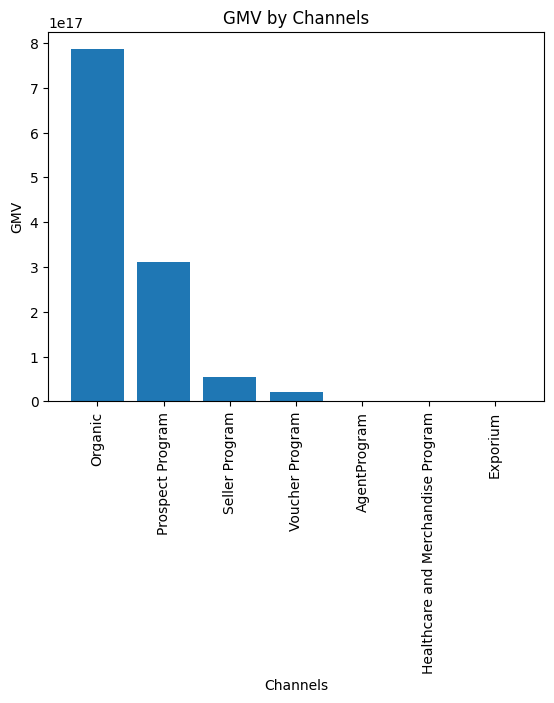

In [ ]:
import matplotlib.pyplot as plt

channel_gmv = df.groupby('channels')['gmv'].sum().sort_values(ascending=False)

plt.bar(channel_gmv.index, channel_gmv)
plt.xlabel('Channels')
plt.ylabel('GMV')
plt.title('GMV by Channels')
plt.xticks(rotation=90)
plt.show()


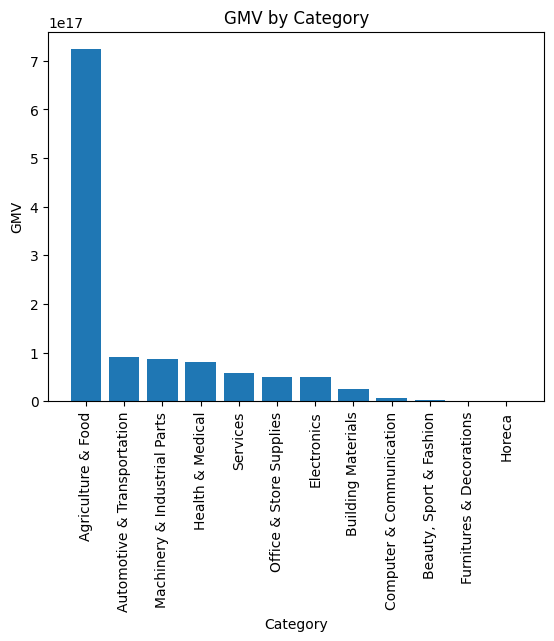

In [ ]:
category_gmv = df.groupby('category')['gmv'].sum().sort_values(ascending=False)

plt.bar(category_gmv.index, category_gmv)
plt.xlabel('Category')
plt.ylabel('GMV')
plt.title('GMV by Category')
plt.xticks(rotation=90)
plt.show()


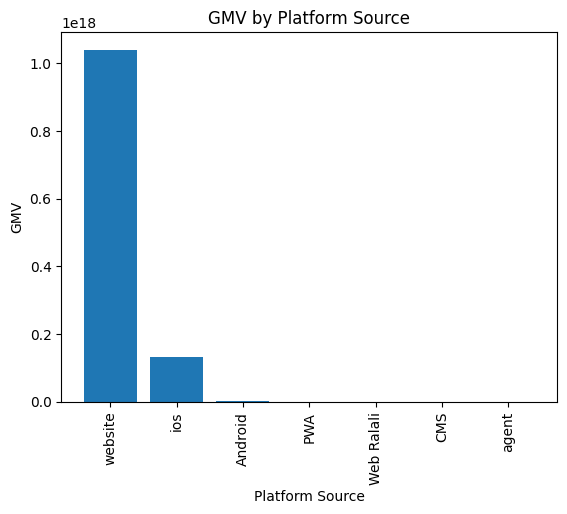

In [ ]:
platform_performance = df.groupby('platform_source')['gmv'].sum().sort_values(ascending=False)

plt.bar(platform_performance.index, platform_performance)
plt.xlabel('Platform Source')
plt.ylabel('GMV')
plt.title('GMV by Platform Source')
plt.xticks(rotation=90)
plt.show()


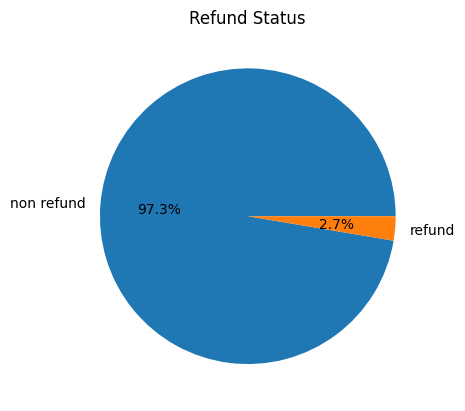

In [ ]:
refund_counts = df['refund_status'].value_counts()

plt.pie(refund_counts, labels=refund_counts.index, autopct='%1.1f%%')
plt.title('Refund Status')
plt.show()


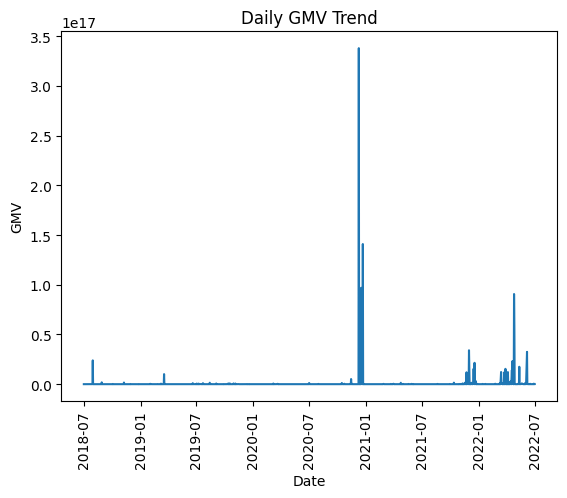

In [ ]:
df['order_date'] = df['order_datetime'].dt.date
daily_gmv = df.groupby('order_date')['gmv'].sum()

plt.plot(daily_gmv.index, daily_gmv)
plt.xlabel('Date')
plt.ylabel('GMV')
plt.title('Daily GMV Trend')
plt.xticks(rotation=90)
plt.show()


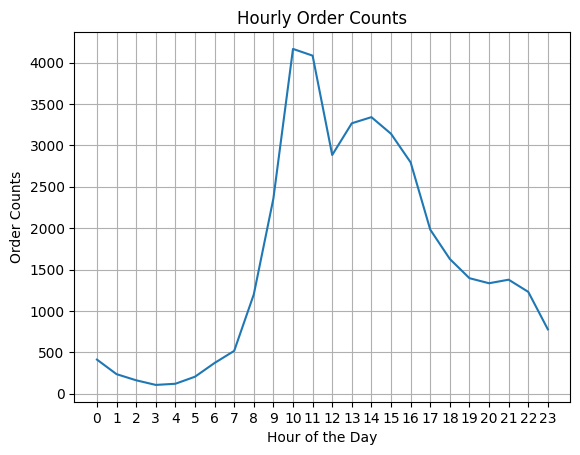

In [ ]:
df['order_hour'] = df['order_datetime'].dt.hour
hourly_order_counts = df.groupby('order_hour')['order_id'].count()

plt.plot(hourly_order_counts.index, hourly_order_counts)
plt.xlabel('Hour of the Day')
plt.ylabel('Order Counts')
plt.title('Hourly Order Counts')
plt.xticks(range(24))
plt.grid(True)
plt.show()


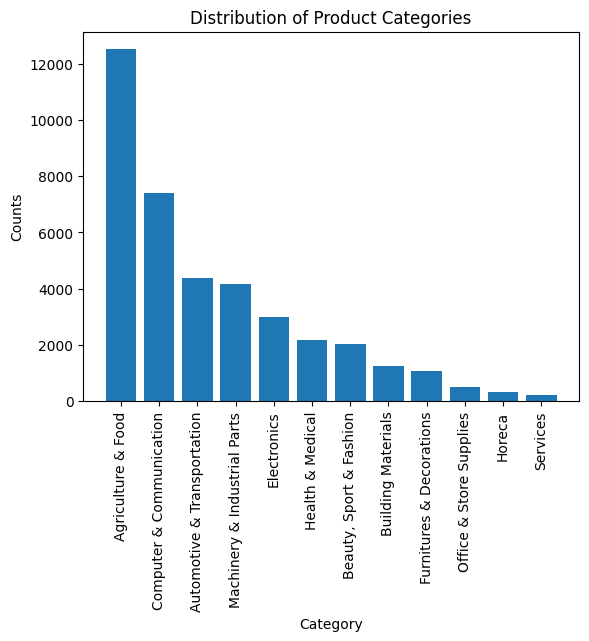

In [ ]:
category_counts = df['category'].value_counts()

plt.bar(category_counts.index, category_counts)
plt.xlabel('Category')
plt.ylabel('Counts')
plt.title('Distribution of Product Categories')
plt.xticks(rotation=90)
plt.show()


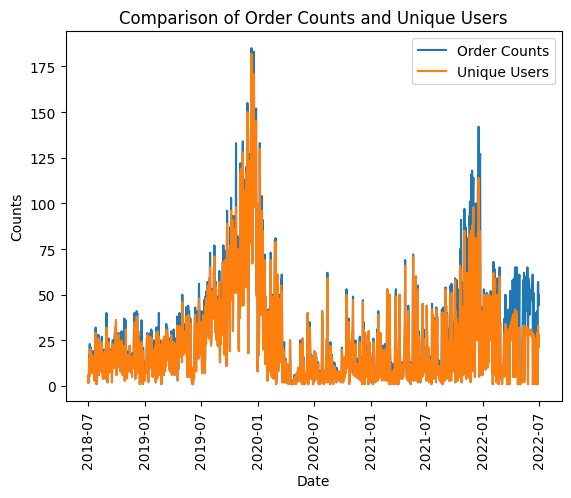

In [ ]:
order_user_counts = df.groupby('order_date').agg({'order_id': 'count', 'user_id': 'nunique'})

plt.plot(order_user_counts.index, order_user_counts['order_id'], label='Order Counts')
plt.plot(order_user_counts.index, order_user_counts['user_id'], label='Unique Users')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.title('Comparison of Order Counts and Unique Users')
plt.xticks(rotation=90)
plt.legend()
plt.show()


#Exploratory Data Analysis




In [ ]:
df.head()

,order_id,user_id,order_source,category,gmv,order_datetime,rejected_datetime,platform_source,user_last_login_datetime,user_register_datetime,channels,segment_category,refund_status,order_date,order_hour
0,BHUhJ1ksV0RjEcF9oQkbQJi0Rrh/NmJBRTo29ReUDPM=,DydI3J1+v/H4wTK8moAOHIZivZfyspk3Kepm38G7bJw=,03. PSP,"Beauty, Sport & Fashion",30000000.0,2022-03-12 10:44:39+00:00,NaT,Android,2022-03-12 10:44:39+00:00,2021-10-27 10:25:44+00:00,Seller Program,3C & Others,non refund,2022-03-12,10
1,+VhWJAaZXDzU63l+jUTWvYLyEeMQ/2ixTT41tm4Fr9w=,DydI3J1+v/H4wTK8moAOHIZivZfyspk3Kepm38G7bJw=,03. PSP,Agriculture & Food,6000000.0,2022-03-14 10:46:35+00:00,NaT,Android,2022-03-14 10:46:35+00:00,2021-10-27 10:25:44+00:00,Seller Program,F & B,non refund,2022-03-14,10
2,QFrBNR0uMfxxQxaMGUUxkmb+wh3qLEPwQY+/JLMUZ1M=,DydI3J1+v/H4wTK8moAOHIZivZfyspk3Kepm38G7bJw=,03. PSP,Agriculture & Food,30000000.0,2022-04-16 08:04:58+00:00,NaT,Android,2022-04-16 08:04:58+00:00,2021-10-27 10:25:44+00:00,Seller Program,F & B,non refund,2022-04-16,8
3,tAhovo1iW5WzCOLpUAbM1Lcp+andZZrxjN2+hsOiABQ=,kEYBJVev9XTppv3P/Dtk7Yc3hPg8cFHAZvu8oWgklFY=,03. PSP,Agriculture & Food,1935000.0,2022-01-21 01:09:05+00:00,NaT,Android,2022-01-21 01:09:05+00:00,2022-01-01 23:52:52+00:00,Seller Program,F & B,non refund,2022-01-21,1
4,Xr3LDnjb7YXrW38OBFEvythV21RA4hLaHYto61nMnak=,DydI3J1+v/H4wTK8moAOHIZivZfyspk3Kepm38G7bJw=,03. PSP,Electronics,30000000.0,2022-04-12 10:13:20+00:00,NaT,Android,2022-04-12 10:13:20+00:00,2021-10-27 10:25:44+00:00,Seller Program,3C & Others,non refund,2022-04-12,10


In [ ]:
# Display the number of rows and columns
print('Shape:', df.shape)

Shape: (40012, 15)


In [ ]:
# Display the column names
print('Columns:', df.columns)

Columns: Index(['order_id', 'user_id', 'order_source', 'category', 'gmv',
       'order_datetime', 'rejected_datetime', 'platform_source',
       'user_last_login_datetime', 'user_register_datetime', 'channels',
       'segment_category', 'refund_status', 'order_date', 'order_hour'],
      dtype='object')


In [ ]:
# Display the data types of each column
print('Data Types:', df.dtypes)

Data Types: order_id                                 object
user_id                                  object
order_source                             object
category                                 object
gmv                                     float64
order_datetime              datetime64[ns, UTC]
rejected_datetime           datetime64[ns, UTC]
platform_source                          object
user_last_login_datetime    datetime64[ns, UTC]
user_register_datetime      datetime64[ns, UTC]
channels                                 object
segment_category                         object
refund_status                            object
order_date                               object
order_hour                                int64
dtype: object


In [ ]:
# Display the summary statistics
print('Summary Statistics:', df.describe())

Summary Statistics:                 gmv    order_hour
count  4.001200e+04  40012.000000
mean   2.984815e+13     13.575877
std    1.944223e+15      4.506460
min    1.000000e+04      0.000000
25%    1.600000e+05     10.000000
50%    2.730000e+06     13.000000
75%    7.920000e+07     16.000000
max    3.380000e+17     23.000000


In [ ]:
df4 = df.groupby('channels')['gmv'].sum().sort_values(ascending=False)
print(df4)

channels
Organic                               7.857205e+17
Prospect Program                      3.315588e+17
Seller Program                        5.504395e+16
Voucher Program                       2.195962e+16
AgentProgram                          1.270872e+12
Healthcare and Merchandise Program    6.652439e+07
Exporium                              3.387128e+07
Name: gmv, dtype: float64


In [ ]:
df6 = df.groupby(df['order_datetime'].dt.year).agg({'gmv': 'sum', 'order_id': 'count', 'user_id': 'count'})
df6

,gmv,order_id,user_id
order_datetime,,,
2018,2.903804e+16,2955,2955
2019,2.300875e+16,16205,16205
2020,6.722916e+17,5931,5931
2021,1.302233e+17,9328,9328
2022,3.397224e+17,5593,5593


The revenue and total user dropped by in 2020, then rose in 2021 only to drop again in 2022.

### Distribution of GMV each year

<ipython-input-30-07bc0d7949cb>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


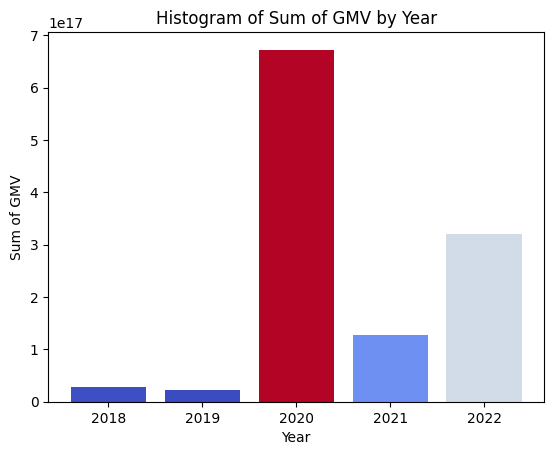

In [ ]:
# Histogram
df7 = df.groupby(df['order_datetime'].dt.year)['gmv'].sum()

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(df7.min(), df7.max())
colors = cmap(norm(df7))

plt.bar(df7.index, df7.values, color=colors)
plt.xlabel('Year')
plt.ylabel('Sum of GMV')
plt.title('Histogram of Sum of GMV by Year')
plt.show()

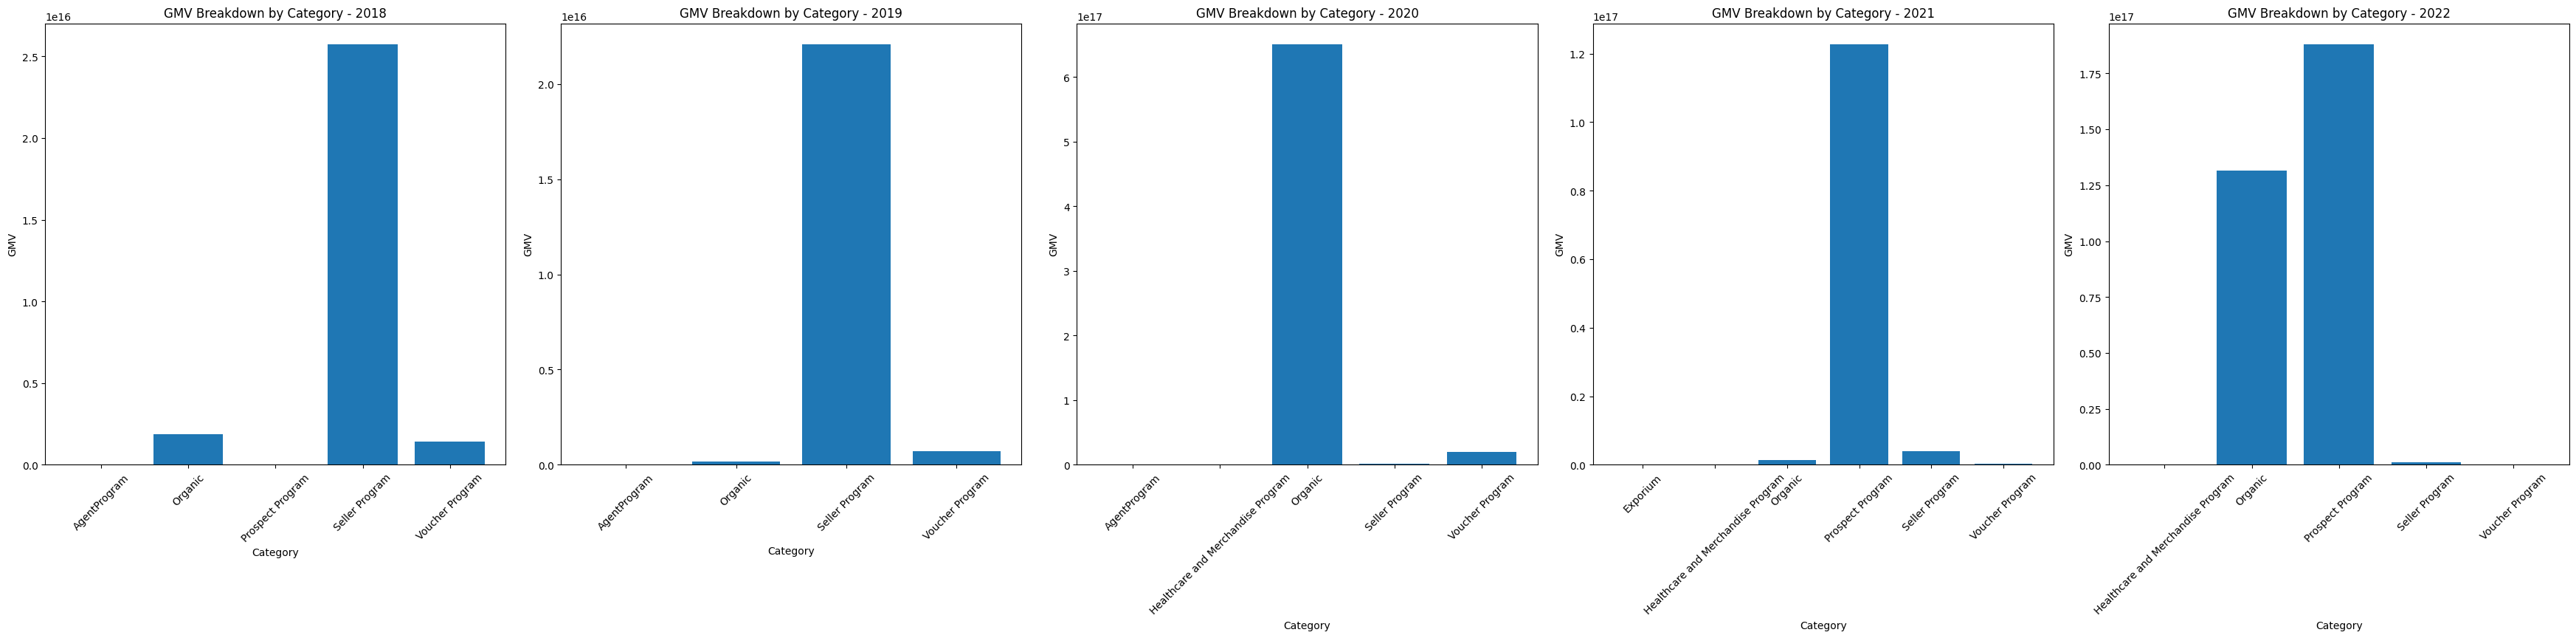

In [ ]:
df7 = df.groupby([df['order_datetime'].dt.year, 'channels'])['gmv'].sum()

categories = df['channels'].unique()

# Calculate the number of rows and columns for subplots
num_years = len(df7.index.levels[0])
num_categories = len(categories)
num_rows = num_years
num_cols = num_categories

# Set the size of the figure based on the number of subplots
fig_width = num_categories * 7
fig_height = num_years * 8
plt.figure(figsize=(fig_width, fig_height))

# Iterate over the years and create a bar chart for each year
for i, year in enumerate(df7.index.levels[0]):
    year_data = df7.loc[year]

    # Create a separate subplot for each year
    plt.subplot(num_rows, num_cols, i + 1)
    plt.bar(year_data.index, year_data.values)
    plt.xlabel('Category')
    plt.ylabel('GMV')
    plt.title(f'GMV Breakdown by Category - {year}')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

Investigate the amount of revenue from organic channel for each year

In [ ]:
organic_df = df[df['channels'] == 'Organic']
df6 = organic_df.groupby(df['order_datetime'].dt.year)['gmv'].sum()
df6

order_datetime
2018    1.854060e+15
2019    1.762733e+14
2020    6.505860e+17
2021    1.373128e+15
2022    1.316000e+17
Name: gmv, dtype: float64

In [ ]:
organic_df = df[df['channels'] == 'Seller Program']
df6 = organic_df.groupby(df['order_datetime'].dt.year)['gmv'].sum()
df6

order_datetime
2018    2.575601e+16
2019    2.210455e+16
2020    2.113874e+15
2021    3.865216e+15
2022    1.204301e+15
Name: gmv, dtype: float64

In [ ]:
voucher_df = df[df['channels'] == 'Voucher Program']
df6 = voucher_df.groupby(df['order_datetime'].dt.year)['gmv'].sum()
df6

order_datetime
2018    1.427948e+15
2019    7.279303e+14
2020    1.959046e+16
2021    2.132802e+14
2022    2.372174e+08
Name: gmv, dtype: float64

Insights
*   In 2018, there were lots of voucher programs (mungkin parts of promotion) but then decrease for each year after
*   In 2022, there's a decrease in voucher program
*   In 2022, the orders are coming from organic and voocher program are dropped (from 1 billion to 8 million and 20 million sequentially)

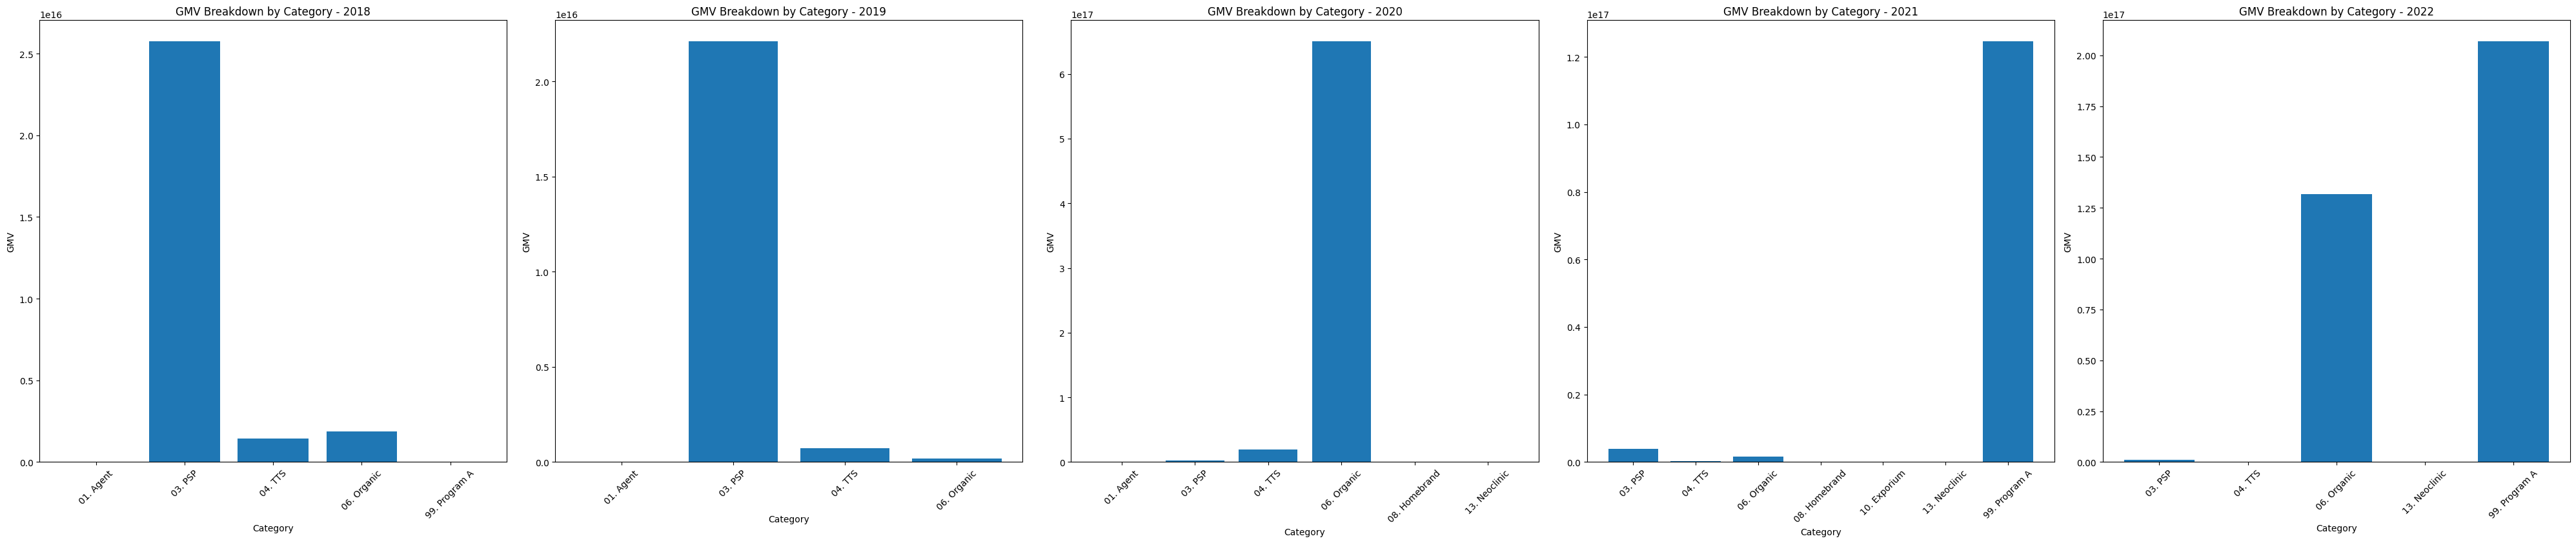

In [ ]:
df7 = df.groupby([df['order_datetime'].dt.year, 'order_source'])['gmv'].sum()

categories = df['channels'].unique()

# Calculate the number of rows and columns for subplots
num_years = len(df7.index.levels[0])
num_categories = len(categories)
num_rows = num_years
num_cols = num_categories

# Set the size of the figure based on the number of subplots
fig_width = num_categories * 8  # Adjust as needed
fig_height = num_years * 8  # Adjust as needed
plt.figure(figsize=(fig_width, fig_height))

# Iterate over the years and create a bar chart for each year
for i, year in enumerate(df7.index.levels[0]):
    year_data = df7.loc[year]

    # Create a separate subplot for each year
    plt.subplot(num_rows, num_cols, i + 1)
    plt.bar(year_data.index, year_data.values)
    plt.xlabel('Category')
    plt.ylabel('GMV')
    plt.title(f'GMV Breakdown by Category - {year}')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

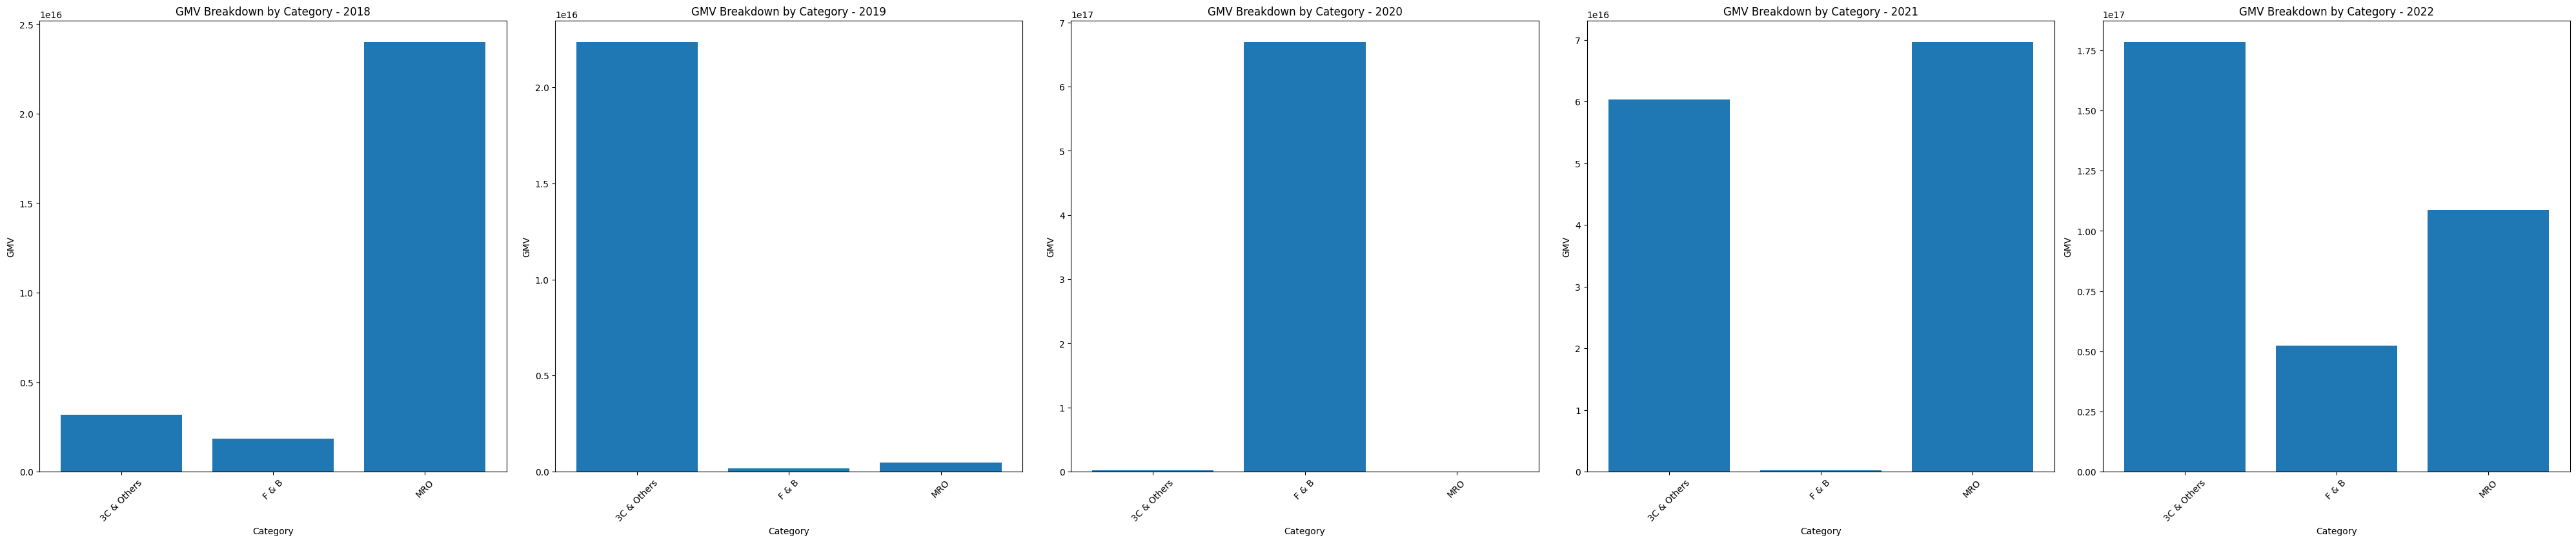

In [ ]:
df7 = df.groupby([df['order_datetime'].dt.year, 'segment_category'])['gmv'].sum()

categories = df['channels'].unique()

# Calculate the number of rows and columns for subplots
num_years = len(df7.index.levels[0])
num_categories = len(categories)
num_rows = num_years
num_cols = num_categories

# Set the size of the figure based on the number of subplots
fig_width = num_categories * 8  # Adjust as needed
fig_height = num_years * 8  # Adjust as needed
plt.figure(figsize=(fig_width, fig_height))

# Iterate over the years and create a bar chart for each year
for i, year in enumerate(df7.index.levels[0]):
    year_data = df7.loc[year]

    # Create a separate subplot for each year
    plt.subplot(num_rows, num_cols, i + 1)
    plt.bar(year_data.index, year_data.values)
    plt.xlabel('Category')
    plt.ylabel('GMV')
    plt.title(f'GMV Breakdown by Category - {year}')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

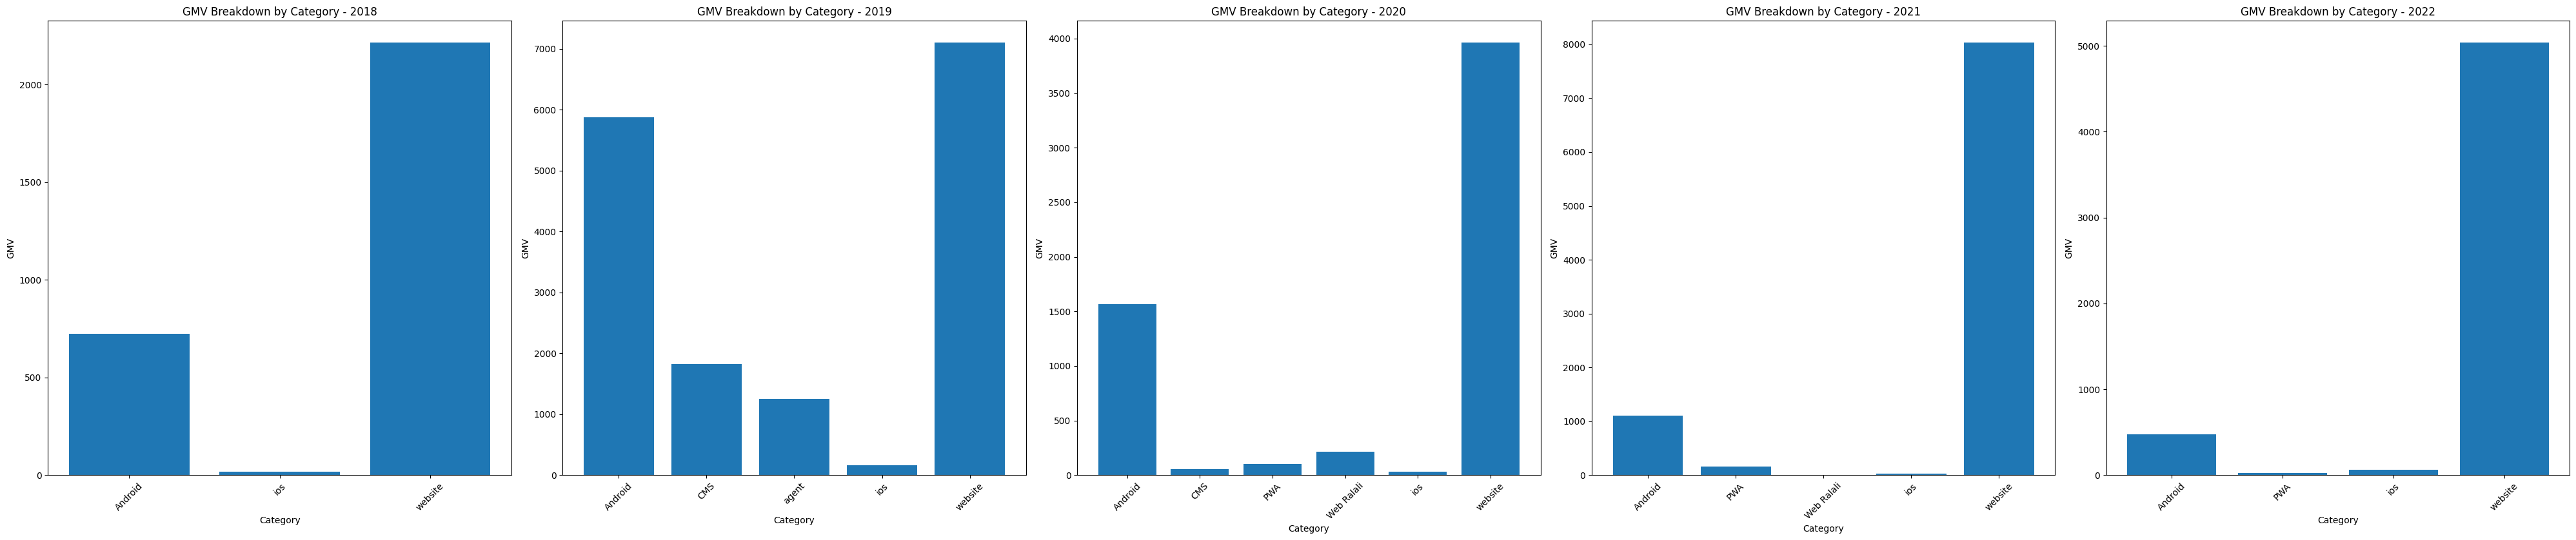

In [ ]:
df7 = df.groupby([df['order_datetime'].dt.year, 'platform_source'])['order_id'].count()

categories = df['channels'].unique()

# Calculate the number of rows and columns for subplots
num_years = len(df7.index.levels[0])
num_categories = len(categories)
num_rows = num_years
num_cols = num_categories

# Set the size of the figure based on the number of subplots
fig_width = num_categories * 8  # Adjust as needed
fig_height = num_years * 8  # Adjust as needed
plt.figure(figsize=(fig_width, fig_height))

# Iterate over the years and create a bar chart for each year
for i, year in enumerate(df7.index.levels[0]):
    year_data = df7.loc[year]

    # Create a separate subplot for each year
    plt.subplot(num_rows, num_cols, i + 1)
    plt.bar(year_data.index, year_data.values)
    plt.xlabel('Category')
    plt.ylabel('GMV')
    plt.title(f'GMV Breakdown by Category - {year}')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [ ]:
website_df = df[df['platform_source'] == 'website']
df6 = website_df.groupby(df['order_datetime'].dt.year)['gmv'].sum()
df6

order_datetime
2018    2.851998e+16
2019    2.198804e+16
2020    6.722523e+17
2021    1.299029e+17
2022    2.080943e+17
Name: gmv, dtype: float64

Most of customers are using website as their main platform

#RFM Analysis

- Segment 1: avg_monthly_gmv < Rp5Mio
- Segment 2: avg_monthly_gmv Rp5-10Mio
- Segment 3: avg_monthly_gmv Rp10-50Mio
- Segment 4: avg_monthly_gmv Rp50-100Mio
- Segment 5: avg_monthly_gmv >100Mio

In [ ]:
import pytz

# Convert all date columns to UTC time zone
df['order_datetime'] = df['order_datetime'].dt.tz_convert(pytz.UTC)
df['rejected_datetime'] = df['rejected_datetime'].dt.tz_convert(pytz.UTC)
df['user_last_login_datetime'] = df['user_last_login_datetime'].dt.tz_convert(pytz.UTC)
df['user_register_datetime'] = df['user_register_datetime'].dt.tz_convert(pytz.UTC)

# Calculate Recency, Frequency, and Monetary
recency = df.groupby('user_id')['order_datetime'].max().reset_index()
recency['Recency'] = (pd.to_datetime('2022-12-31', utc=True) - recency['order_datetime']).dt.days

frequency = df.groupby('user_id')['order_id'].count().reset_index()
frequency = frequency.rename(columns={'order_id': 'Frequency'})

monetary = df.groupby('user_id')['gmv'].sum().reset_index()
monetary = monetary.rename(columns={'gmv': 'Monetary'})

# Combining Recency, Frequency, and Monetary data
rfm_data = pd.merge(recency, frequency, on='user_id')
rfm_data = pd.merge(rfm_data, monetary, on='user_id')

# Create a function to categorize segments based on monthly GMV average
def categorize_segment(row):
    if row['Monetary'] < 5000000:
        return 'Segment 1'
    elif row['Monetary'] >= 5000000 and row['Monetary'] < 10000000:
        return 'Segment 2'
    elif row['Monetary'] >= 10000000 and row['Monetary'] < 50000000:
        return 'Segment 3'
    elif row['Monetary'] >= 50000000 and row['Monetary'] < 100000000:
        return 'Segment 4'
    else:
        return 'Segment 5'

# Implement segment categorization functionality
rfm_data['Segment'] = rfm_data.apply(categorize_segment, axis=1)

# View RFM Analysis results
rfm_data['Segment'].value_counts()


Segment 1    13098
Segment 5     4307
Segment 3     1290
Segment 4      507
Segment 2      477
Name: Segment, dtype: int64

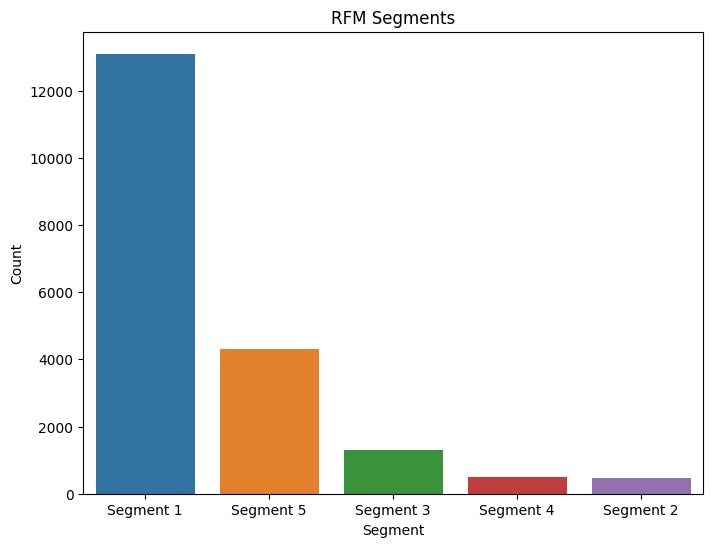

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of users in each segment
segment_counts = rfm_data['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

# Bar chart for the number of users in each segment
plt.figure(figsize=(8, 6))
sns.barplot(data=segment_counts, x='Segment', y='Count')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.title('RFM Segments')
plt.show()
